# Corsair Data Analytics On Amazon Reviews

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud

from matplotlib import pyplot as plt
from pandarallel import pandarallel

from reviews.config import processed_data_dir

pandarallel.initialize(progress_bar=False, nb_workers=8)

from matplotlib.ticker import FuncFormatter

sns.set_style(style="darkgrid")

primary_color = "#ECE81A"  # 108de4ff"
secondary_color = "#C3C5C5"

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Read Data

In [2]:
data_df = pd.read_json(processed_data_dir / "products_reviews.json.gz")

data_df["asin"] = data_df["asin"].astype("category")
data_df["text"] = data_df["text"].astype("string")
data_df["summary"] = data_df["summary"].astype("string")
data_df["overall"] = data_df["overall"].astype("category")
data_df["brand"] = data_df["brand"].astype("category")
data_df["category"] = data_df["category"].astype("category")
data_df["description"] = data_df["description"].astype("string")
data_df["title"] = data_df["title"].astype("string")

data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28983 entries, 0 to 28982
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   asin             28983 non-null  category      
 1   overall          28983 non-null  category      
 2   reviewerID       28983 non-null  object        
 3   summary          28983 non-null  string        
 4   text             28983 non-null  string        
 5   timestamp        28983 non-null  datetime64[ns]
 6   vote             28983 non-null  int64         
 7   brand            28983 non-null  category      
 8   category         28983 non-null  category      
 9   description      28139 non-null  string        
 10  imageURLHighRes  24005 non-null  object        
 11  price            18830 non-null  float64       
 12  title            28983 non-null  string        
dtypes: category(4), datetime64[ns](1), float64(1), int64(1), object(2), string(4)
memory usage:

In [3]:
data_df.head(5)

,asin,overall,reviewerID,summary,text,timestamp,vote,brand,category,description,imageURLHighRes,price,title
0,B0009PAZ0Q,5,A2SOTPCGTVXK72,"good product, I recommend it","good product, I recommend it, that card looks ...",2013-06-24,0,corsair,Memory,Are you looking for a performance upgrade for ...,https://images-na.ssl-images-amazon.com/images...,1.54,Corsair 1GB (1x1GB) DDR2 533 MHz (PC2 4200) La...
1,B00K23BUEK,5,AJCXMX78W8UAZ,"It's beautiful, and has some cool features","It's beautiful, and has some cool features. Th...",2015-03-27,4,msi,Motherboards,"MSI Z97S SLI Krait Edition: Socket LGA 1150, I...",https://images-na.ssl-images-amazon.com/images...,NaN,MSI Intel Z97 LGA 1150 DDR3 USB 3.1 ATX Mother...
2,B007V4DSJS,5,A2ZGN3FCLSMQUX,After one incorrect order for memory for this ...,After one incorrect order for memory for this ...,2014-10-15,0,komputerbay,Memory,"While at first glance, it may be in your best ...",None,5.35,Komputerbay 8GB (2 X 4GB) DDR2 DIMM (240 pin) ...
3,B005B0A6ZS,5,A1J5IZ8E767S1B,It does what I need: makes more ATA ports ...,It does what I need: makes more ATA ports ava...,2015-10-30,0,io crest,I/O Port Cards,The IO Crest 2 Port SATA III 6Gbps PCI-Express...,https://images-na.ssl-images-amazon.com/images...,14.59,IO Crest 2-port SATA III PCIe 2.0 x2 Controlle...
4,B00MMLXIKY,2,A32LLIL80MJ314,Two Stars,Underwhelming.,2016-03-20,0,intel,CPU Processors,"With faster, intelligent, multi-core technolog...",https://images-na.ssl-images-amazon.com/images...,7.80,Intel Core i7-5820K Desktop Processor (6-Cores...


# EDA

### ASIN

In [4]:
print("Products:", len(data_df.asin.unique()))

data_df.asin.value_counts()

Products: 4803


B005LDLP8W    432
B0092ML0MY    290
B00J8E8XT4    272
B006WAGG14    217
B0026ZPFCK    214
             ... 
B0085MH238      1
B0085MPDCU      1
B00885FJOQ      1
B0088JQ2Z2      1
B01HIWBNOY      1
Name: asin, Length: 4803, dtype: int64

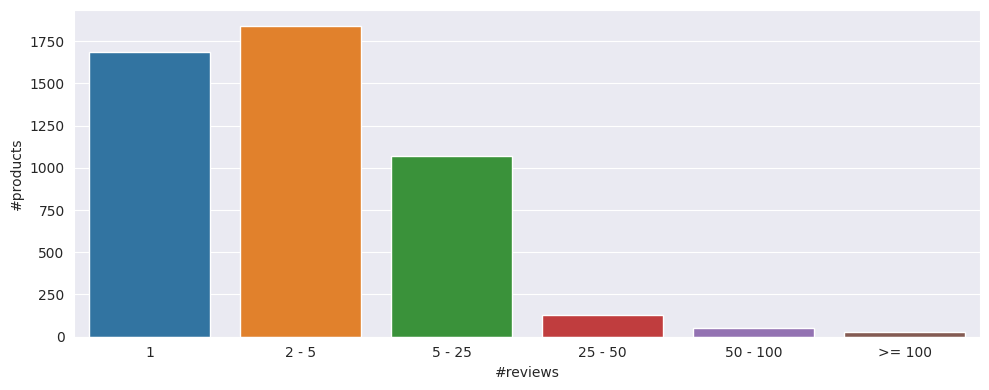

In [5]:
def discretize_counts(length, limits):
    if length < limits[0]:
        return f"< {limits[0]}"

    k = 0
    while length < limits[-1]:
        if limits[k] <= length < limits[k + 1]:
            return f"{limits[k]} - {limits[k + 1]}"
        k = k + 1

    return f">= {limits[-1]}"


def get_counts_category(limits):
    cats = [f"< {limits[0]}"]

    for i in range(len(limits) - 1):
        cats.append(f"{limits[i]} - {limits[i + 1]}")

    cats.append(f">= {limits[-1]}")

    return pd.CategoricalDtype(cats, ordered=True)


limits = [2, 5, 25, 50, 100]

x = data_df.asin.value_counts().apply(lambda x: discretize_counts(x, limits))
x = x.reset_index().asin.value_counts().rename("count")

reviews_per_prod = pd.DataFrame(x).reset_index(names="#reviews")
reviews_per_prod["#reviews"] = reviews_per_prod["#reviews"].astype(
    get_counts_category(limits)
)
reviews_per_prod["#reviews"] = reviews_per_prod["#reviews"].apply(
    lambda x: "1" if x == "< 2" else x
)

fig = plt.figure(figsize=(10, 4))
ax = sns.barplot(reviews_per_prod, x="#reviews", y="count")
ax.set_ylabel("#products")
ax.set_xlabel("#reviews")
fig.tight_layout()

### Timestamp

In [6]:
# number of reviews over time (lineplot)
# number of products(asin) over time (lineplot)

### Brand

In [7]:
# number of reviews per brand (barplot)

### Category

In [8]:
# number of reviews per category (barplot)

### Overall

In [9]:
# star distribution (barplot)
# mean value

# Corsair

### Select Corsair specific Data

In [10]:
sns.set_style("white")
corsair_df = data_df[data_df["brand"] == "corsair"].copy()
corsair_df.head(5)

,asin,overall,reviewerID,summary,text,timestamp,vote,brand,category,description,imageURLHighRes,price,title
0,B0009PAZ0Q,5,A2SOTPCGTVXK72,"good product, I recommend it","good product, I recommend it, that card looks ...",2013-06-24,0,corsair,Memory,Are you looking for a performance upgrade for ...,https://images-na.ssl-images-amazon.com/images...,1.54,Corsair 1GB (1x1GB) DDR2 533 MHz (PC2 4200) La...
5,B00F6S10KK,5,A3H5L8YVOFHSQ7,nice,great fans. nice lights.,2016-10-05,0,corsair,Fans & Cooling,Superior cooling performance and LED illuminat...,https://images-na.ssl-images-amazon.com/images...,2.54,Corsair Air Series AF120 LED Quiet Edition Hig...
14,B0092ML0MY,4,A2D57GCLH76X9C,Just what you want from a PSU/ I have had good...,Plugged it in and it powered up. Just what you...,2017-04-30,0,corsair,Power Supplies,The Corsair Builder Series of PSUs are designe...,https://images-na.ssl-images-amazon.com/images...,4.16,Corsair CX Series 500 Watt 80 Plus Bronze Cert...
26,B006ON5KZC,5,A2EZBKKBVLNXQ4,Great RAM.,Works! Need I say more? Great RAM.,2016-04-06,0,corsair,Memory,"For Apple 2011 MacBook Pro, Mac Mini, and iMac...",None,3.55,Corsair Apple Certified 16GB (2 x 8GB) DDR3 13...
36,B00L64NSL2,5,A2QBYJBRC0TVLD,Keeps my case nice and cool with a little bit ...,Keeps my case nice and cool with a little bit ...,2017-04-11,0,corsair,Fans & Cooling,Corsair CO-9050032-WW SP120 Twin Dual Pack 120...,https://images-na.ssl-images-amazon.com/images...,2.54,Corsair Air Series SP 120 LED Green High Stat...


### Number of reviews for each reviewerID (to ensure that the reviews are not all from the same person)

In [11]:
"Number of unique reviwers: {}, Average Number of Reviews per single reviwer: {}".format(
    corsair_df["reviewerID"].nunique(), corsair_df["reviewerID"].value_counts().mean()
)

'Number of unique reviwers: 2638, Average Number of Reviews per single reviwer: 1.0261561789234268'

### Number of Products Reviewed and total Number of Reviews

In [12]:
corsair_df["asin"] = corsair_df["asin"].astype("string").astype("category")

"Number of total Reviews: {}, Number of total Products Reviwed: {}, Mean Number of Reviews Per Product: {}".format(
    len(corsair_df),
    len(corsair_df["asin"].unique()),
    corsair_df["asin"].value_counts().mean(),
)

'Number of total Reviews: 2707, Number of total Products Reviwed: 232, Mean Number of Reviews Per Product: 11.668103448275861'

### Reviews Over Time
- Looking the number of reviews over the years we can see the raising in the interest of people in ~2012 to ~2016 then decreasing until 2018
- Looking at how many reviews they have on average per week/month telling us how much the customers are active

In [13]:
corsair_df["period"] = corsair_df["timestamp"].dt.to_period("M")
corsair_df.sort_values(by="period", inplace=True)
products_launch_df = corsair_df.drop_duplicates("asin", keep="first").copy().reindex()
# print(corsair_df[corsair_df["asin"] == "B01G5I6Q94"]["timestamp"])
# corsair_df.drop_duplicates(keep="first")
# corsair_df.drop_duplicates("asin", keep="first")

# print(products_launch_df[corsair_df["asin"] == "B01G5I6Q94"]["timestamp"])

products_launch_df["period"].value_counts().reset_index()

,index,period
0,2013-02,7
1,2012-08,6
2,2014-01,6
3,2014-02,6
4,2012-06,6
...,...,...
90,2012-04,1
91,2008-03,1
92,2014-06,1
93,2014-10,1


In [14]:
def plot_reviews_over_time(period="M"):
    corsair_df["period"] = corsair_df["timestamp"].dt.to_period(period)
    corsair_df["period"] = corsair_df["period"].dt.to_timestamp()

    corsair_df.sort_values(by="period", inplace=True)
    products_launch_df = corsair_df.drop_duplicates("asin", keep="first")

    x = pd.DataFrame(
        corsair_df["period"]
        .value_counts()
        .reset_index()
        .rename(columns={"index": "period", "period": "count"})
    )

    # n. products launch in a period
    y = pd.DataFrame(
        products_launch_df["period"]
        .value_counts()
        .reset_index()
        .rename(columns={"index": "period", "period": "count"})
    )

    import plotly.express as px

    # fig = px.bar(x, x="period", y="count", height=500, width=2000, color_discrete_sequence=[secondary_color])
    # fig.update_layout({
    # 'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    # 'paper_bgcolor': 'rgba(0, 0, 0, 0)',
    # })
    # # cambiare colori editor per salvare il grafico
    # fig.update_xaxes(showgrid=False, zeroline=False, title=None)
    # fig.update_yaxes(showgrid=False, zeroline=False, title=None)
    # fig.write_image("../output/reviews_over_time.png")
    # fig

    period_lbl = "Year" if period == "Y" else ("Month" if period == "M" else "Day")

    fig = plt.figure(figsize=(16, 4))
    ax = sns.lineplot(x, x="period", y="count", color=secondary_color, marker="o")
    sns.despine(left=True, bottom=True)
    ax.set_title(f"Number of Reviews by {period_lbl}")
    ax.set_xlabel("")
    ax.set_ylabel("")
    sns.lineplot(y, x="period", y="count", color=secondary_color, marker="o", ax=ax)
    fig.tight_layout()

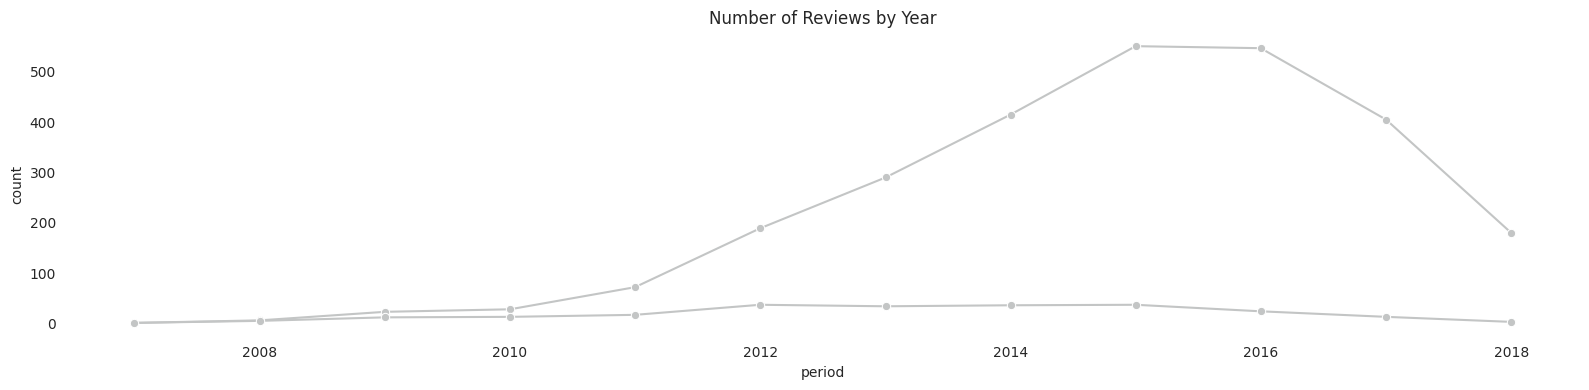

In [15]:
plot_reviews_over_time(period="Y")

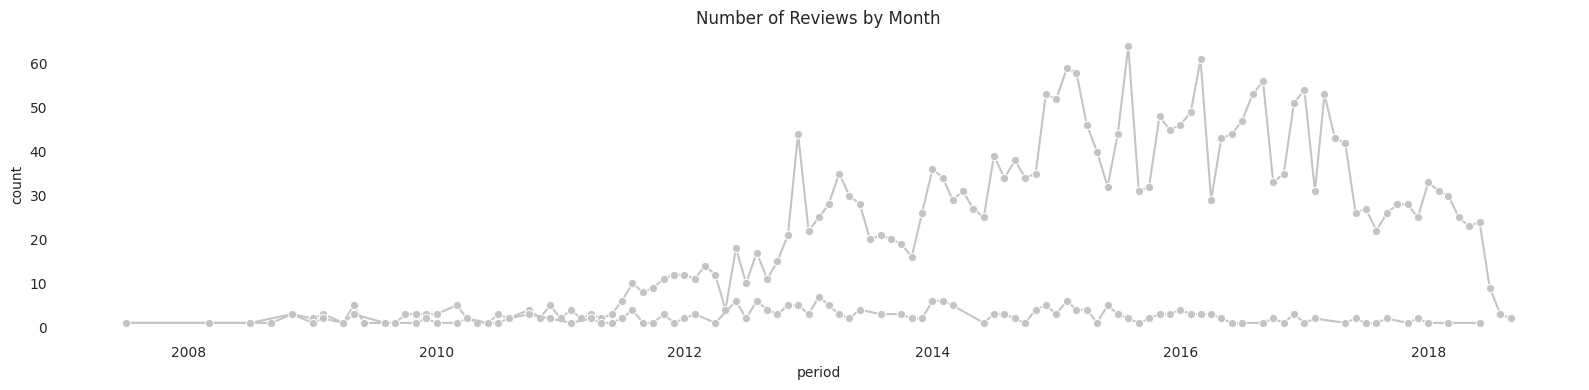

In [16]:
plot_reviews_over_time(period="M")

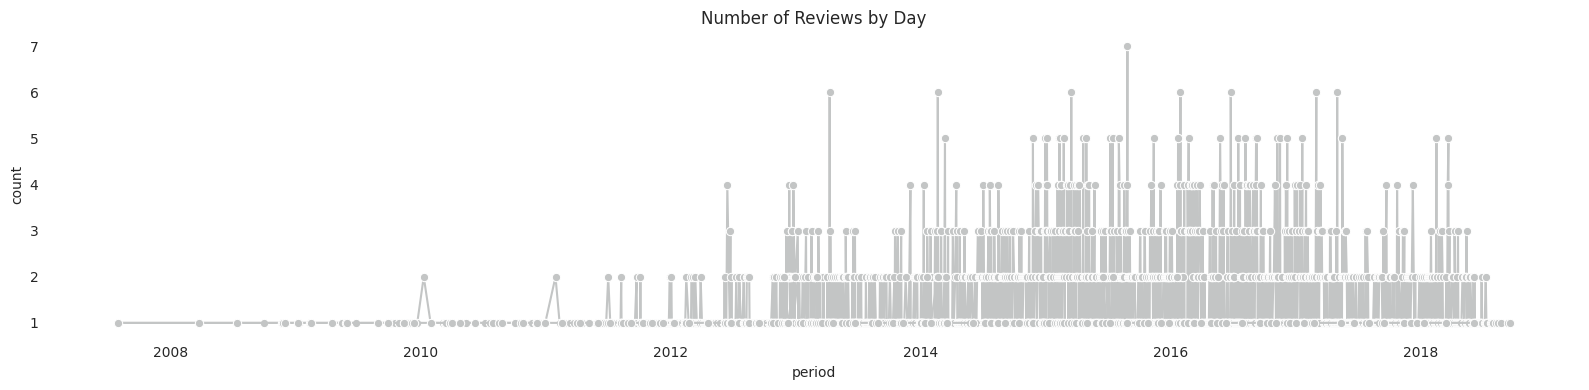

In [17]:
plot_reviews_over_time(period="D")

### Reviews Ratings (how satisfied customers feel with our brand products)

Average Rating: 4.50


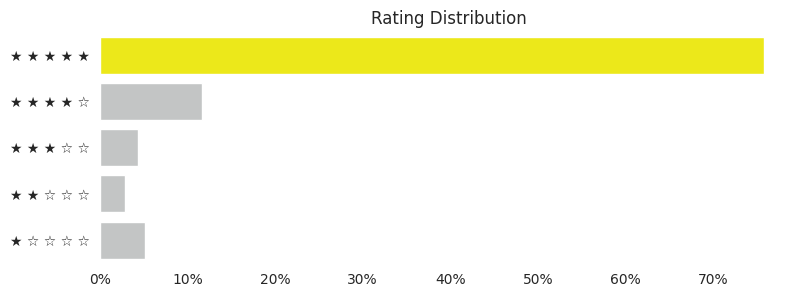

In [18]:
rating_df = (
    corsair_df["overall"]
    .value_counts(normalize=True)
    .reset_index()
    .rename(columns={"index": "rating", "overall": "percentage"})
)

rating_df = pd.DataFrame(rating_df)
rating_df["rating"] = rating_df["rating"].astype("category")
rating_df["color"] = rating_df["rating"].apply(
    lambda x: primary_color if x == 5 else secondary_color
)
rating_df["percentage"] = rating_df["percentage"] * 100

barplot_palette = (
    pd.DataFrame(rating_df.groupby(["rating", "percentage"])["color"].value_counts())
    .rename(columns={"color": "count2"})
    .reset_index()
    .sort_values(by="percentage", ascending=False)
)
order = [5, 4, 3, 2, 1]

fig = plt.figure(figsize=(9, 3))
ax = sns.barplot(
    rating_df,
    x="percentage",
    y="rating",
    order=order,
    palette=barplot_palette["color"],
    saturation=1,
)
sns.despine(left=True, bottom=True)
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}%"))
ax.set_title("Rating Distribution")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_yticklabels([" ".join((["★"] * r) + (["☆"] * (5 - r))) for r in order])

print("Average Rating: {:,.2f}".format(corsair_df["overall"].astype("float").mean()))

### Most Reviewed Categories (the main categories that our brand deals with)

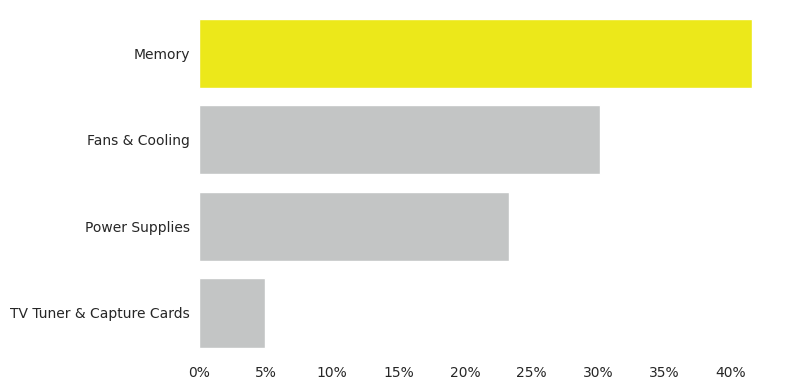

In [19]:
fig = plt.figure(figsize=(8, 4))

category_df = (
    pd.DataFrame(corsair_df["category"].value_counts())
    .reset_index()
    .rename(columns={"index": "category", "category": "count"})
)

category_df[category_df["count"] <= 0] = np.nan
category_df.dropna(inplace=True)
category_df["category"] = category_df["category"].astype("category")
category_df["count"] = category_df["count"].astype("int")

category_df["count"] = category_df["count"] / len(corsair_df) * 100

category_df["color"] = category_df["count"].apply(
    lambda x: primary_color if x == category_df["count"].max() else secondary_color
)

barplot_palette = (
    pd.DataFrame(category_df.groupby(["category", "count"])["color"].value_counts())
    .rename(columns={"color": "count2"})
    .reset_index()
    .sort_values(by="count", ascending=False)["color"]
)

ax = sns.barplot(
    category_df,
    x="count",
    y="category",
    order=category_df.sort_values(by="count", ascending=False)["category"],
    palette=barplot_palette,
    saturation=1,
)
sns.despine(left=True, bottom=True)
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}%"))
fig.tight_layout()

plt.legend([], [], frameon=False)

### Number of Reviews per Price (telling us at what price people are more willing to buy)

In [20]:
price_categories = pd.CategoricalDtype(
    categories=[
        "Under \$25",
        "\$25 to \$50",
        "\$50 to \$100",
        "\$100 to \$200",
        "\$200 & Above",
    ],
    ordered=True,
)

corsair_df["price"] = corsair_df["price"].apply(
    lambda x: "Under \$25"
    if x < 25
    else (
        "\$25 to \$50"
        if x < 50
        else (
            "\$50 to \$100"
            if x < 100
            else ("\$100 to \$200" if x < 200 else "\$200 & Above")
        )
    )
)
corsair_df["price"] = corsair_df["price"].astype(price_categories)

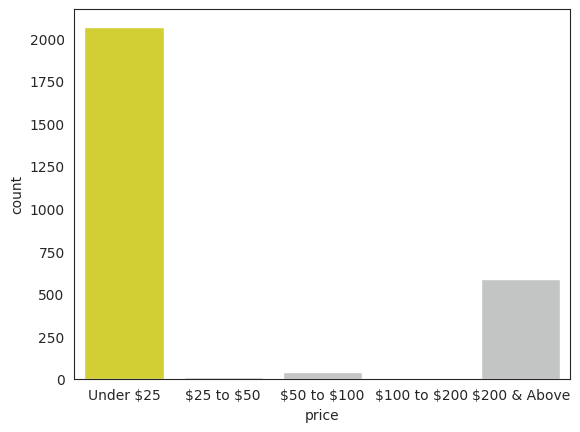

In [21]:
price_palette = []
categories = [
    "Under \$25",
    "\$25 to \$50",
    "\$50 to \$100",
    "\$100 to \$200",
    "\$200 & Above",
]
for x in categories:
    if x == "Under \$25":
        price_palette.append(primary_color)
    else:
        price_palette.append(secondary_color)

ax = sns.countplot(corsair_df, x="price", palette=price_palette)
fig.tight_layout()

### Corsairs' competitors
- Most Reviewed Brands of the Memory Category
- Most Reviewed Brands of the Fans & Cooling Category
- Most Reviewed Brands of the Power Supplies Category
- Most Reviewed Brands of the TV Tuner & Capture Cards Category

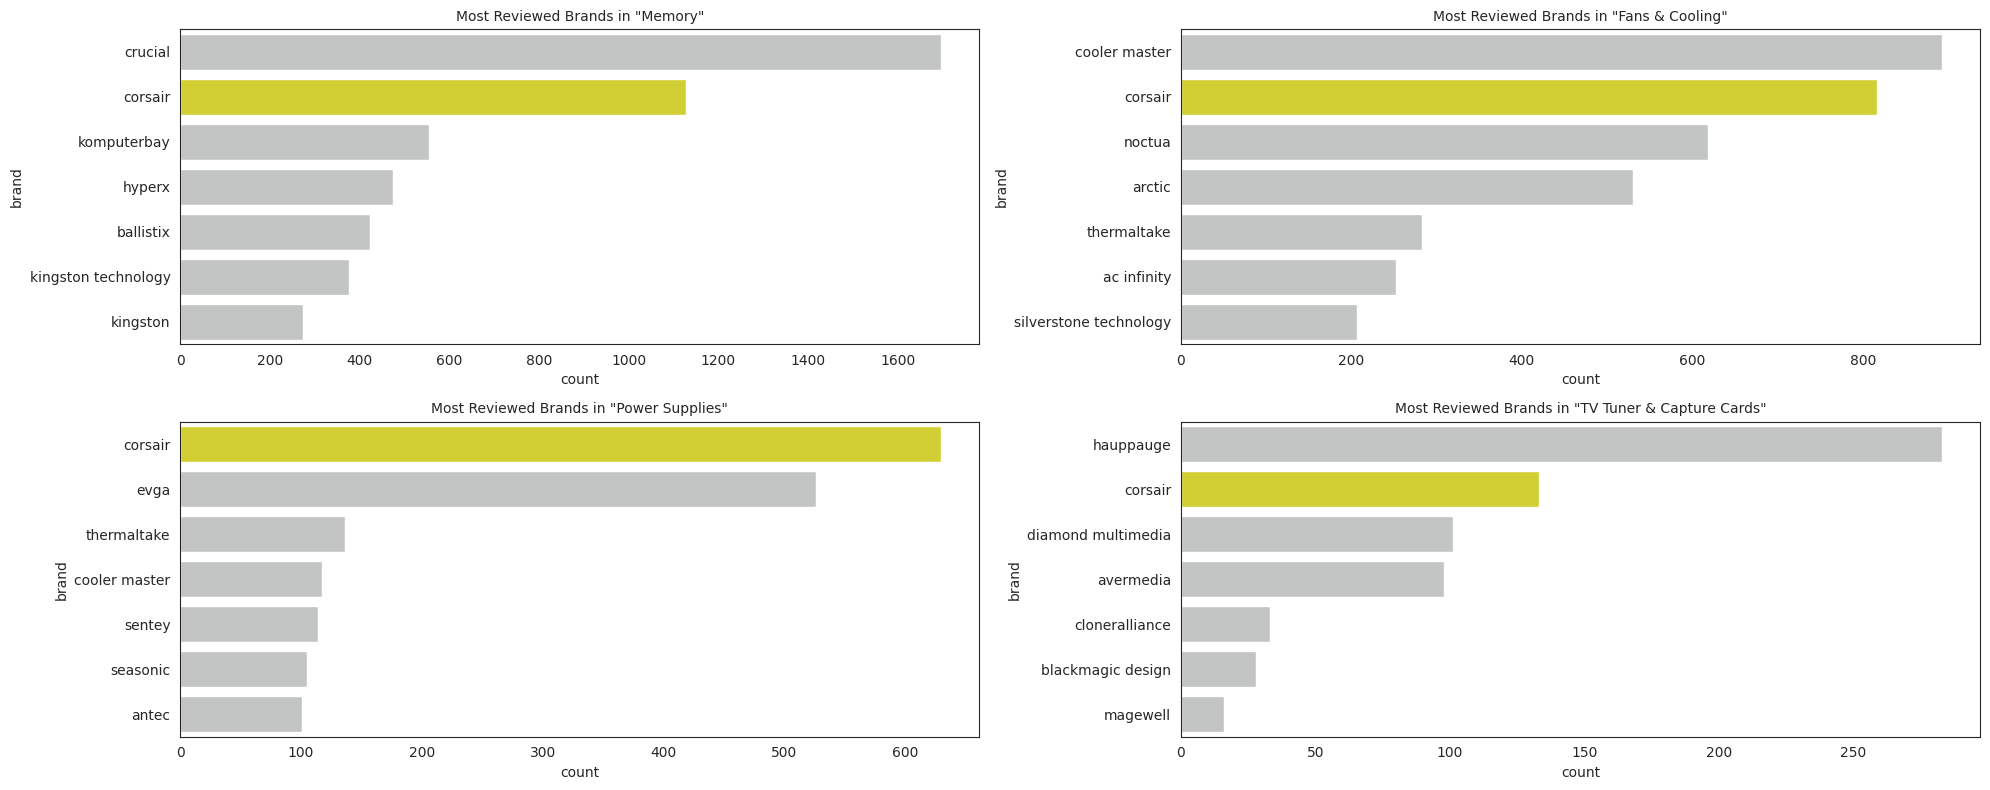

In [22]:
def competitors_by_category(data_df, category, ax):
    category_df = data_df[data_df["category"] == category]
    mc_category_brands_df = (
        pd.DataFrame(Counter(category_df["brand"].tolist()).most_common(7))
        .reset_index()
        .rename(columns={0: "brand", 1: "count"})
    )

    mc_category_brands_df["color"] = mc_category_brands_df["brand"].apply(
        lambda x: primary_color if x == "corsair" else secondary_color
    )

    barplot_palette = (
        pd.DataFrame(
            mc_category_brands_df.groupby(["brand", "count"])["color"].value_counts()
        )
        .rename(columns={"color": "count2"})
        .reset_index()
        .sort_values(by="count", ascending=False)["color"]
    )

    plot = sns.barplot(
        mc_category_brands_df,
        x="count",
        y="brand",
        order=mc_category_brands_df.sort_values(by="count", ascending=False)["brand"],
        palette=barplot_palette,
        ax=ax,
    )
    plot.set_title(f'Most Reviewed Brands in "{category}"', fontsize=10)
    return plot


fig, axes = plt.subplots(2, 2, figsize=(20, 8))
axes = axes.flatten()
competitors_by_category(data_df, "Memory", axes[0])
competitors_by_category(data_df, "Fans & Cooling", axes[1])
competitors_by_category(data_df, "Power Supplies", axes[2])
competitors_by_category(data_df, "TV Tuner & Capture Cards", axes[3])
fig.tight_layout()
plt.savefig('competitors.png')

### Top 30 Most Common Votes (we can see how people usually don't vote on reviews or very few do)

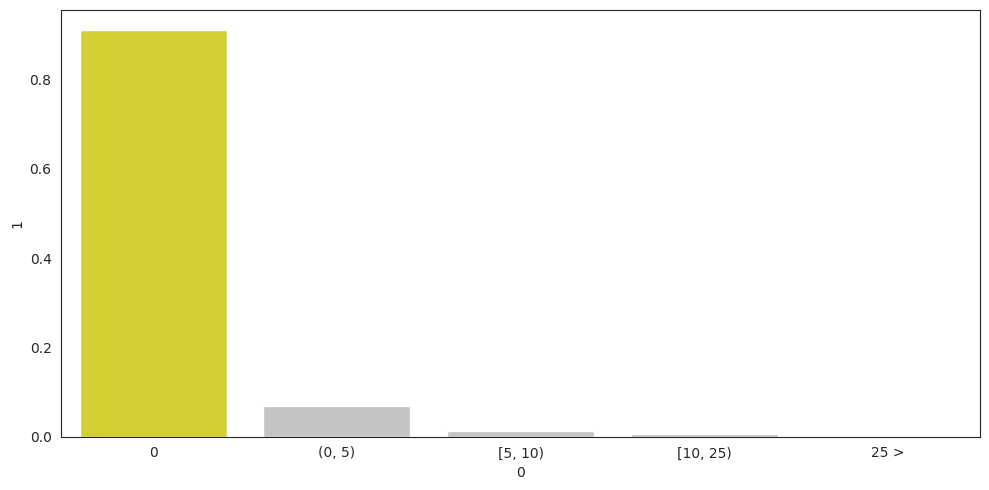

In [23]:
def discretize_vote(vote):
    if 0 < vote < 5:
        return "(0, 5)"
    if 5 <= vote < 10:
        return "[5, 10)"
    if 10 <= vote < 25:
        return "[10, 25)"
    if 25 <= vote:
        return "25 >"

    return "0"


vote_df = pd.DataFrame(
    Counter(corsair_df["vote"].apply(discretize_vote).tolist()).most_common()
)
vote_df[1] = vote_df[1] / vote_df[1].sum()

vote_df["color"] = vote_df[1].apply(
    lambda x: primary_color if x == vote_df[1].max() else secondary_color
)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=vote_df[0], y=vote_df[1], ax=ax, palette=vote_df["color"])
fig.tight_layout()

### Review Summary & Text

##### Summary

In [24]:
text_lengths = corsair_df["summary"].str.len()
mean_length = np.round(np.mean(text_lengths))
print("Mean Review Summary Length:", mean_length, "characters\n")

print("Some Review Summary Examples:\n")

k = 5
for x in corsair_df["summary"]:
    if k < 0:
        break
    else:
        print(x + "\n")
        k = k - 1

Mean Review Summary Length: 26.0 characters

Some Review Summary Examples:

Good and stable memories

I Have The Power!

Great mid-level power supply

Great product

First Time Installation

talking about the best



In [25]:
def discretize_length(length, limits):
    if length < limits[0]:
        return f"< {limits[0]}"

    k = 0
    while length < limits[-1]:
        if limits[k] <= length < limits[k + 1]:
            return f"{limits[k]} - {limits[k + 1]}"
        k = k + 1

    return f">= {limits[-1]}"


def get_lengths_category(limits):
    cats = [f"< {limits[0]}"]

    for i in range(len(limits) - 1):
        cats.append(f"{limits[i]} - {limits[i + 1]}")

    cats.append(f">= {limits[-1]}")

    return pd.CategoricalDtype(cats, ordered=True)

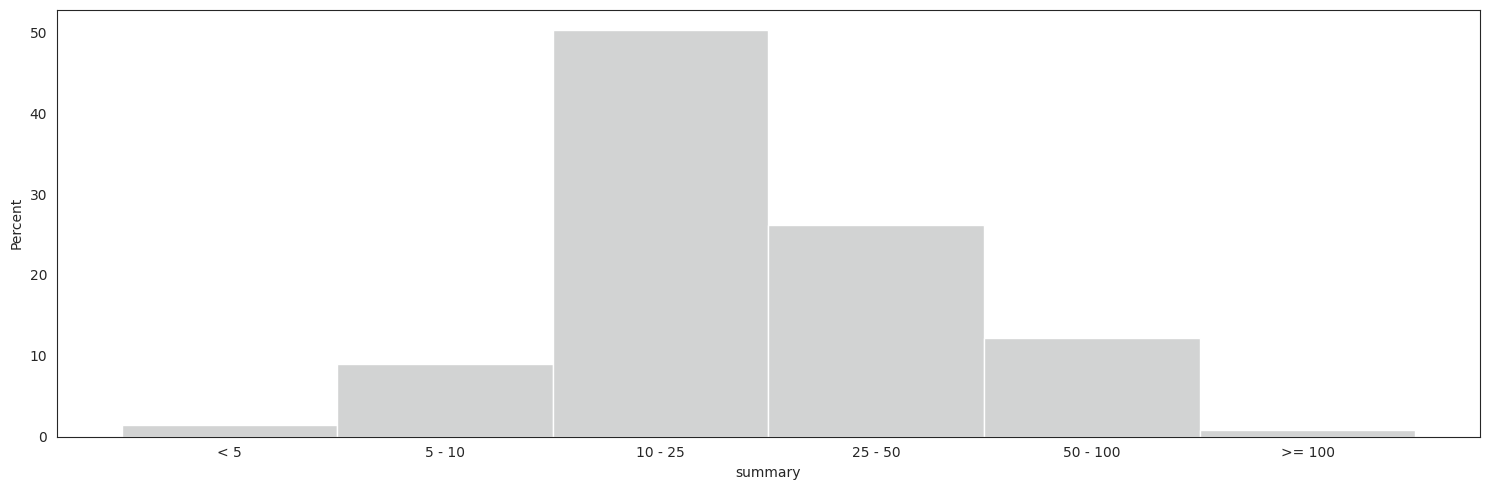

In [26]:
limits = [5, 10, 25, 50, 100]

fig, ax = plt.subplots(figsize=(15, 5))
lengths = corsair_df["summary"].str.len().apply(lambda x: discretize_length(x, limits))
lengths = lengths.astype(get_lengths_category(limits))
sns.histplot(x=lengths, stat="percent", ax=ax, color=secondary_color)

fig.tight_layout()

##### Text

In [27]:
text_lengths = corsair_df["text"].str.len()
mean_length = np.round(np.mean(text_lengths))
print("Mean Review Text Length:", mean_length, "characters\n")

print("Some Review Text Examples:\n")

k = 5
for x in corsair_df["text"]:
    if k < 0:
        break
    else:
        print(x + "\n")
        k = k - 1

Mean Review Text Length: 289.0 characters

Some Review Text Examples:

I have also a twin memory modules of this memory but PC6400 and they work just sweet. Fair enough for gaming. Looks good on its heat sink but what is important is the performance. This memory rules.

If you need power for your PC, look no further.  This unit has all the power and then some.  It'll run everything in your rig quietly and cooly.  The fan is ultra quiet.  It's got tons of connections.  The cables appear to be high quality.  It's very sturdy.  If you are a hard-core gamer with power intensive components, then this is your power supply.

I've only had this a few weeks, but this is an excellent mid-level power supply that should suit the needs of most desktop users (except hardcore gamers).  Extremely quiet and stable.  Pretty simple upgrade to do on the standard power supply that came with my OEM desktop.  This unit is standard ATX size and should fit inside any mid-tower case.  It has plenty of connectio

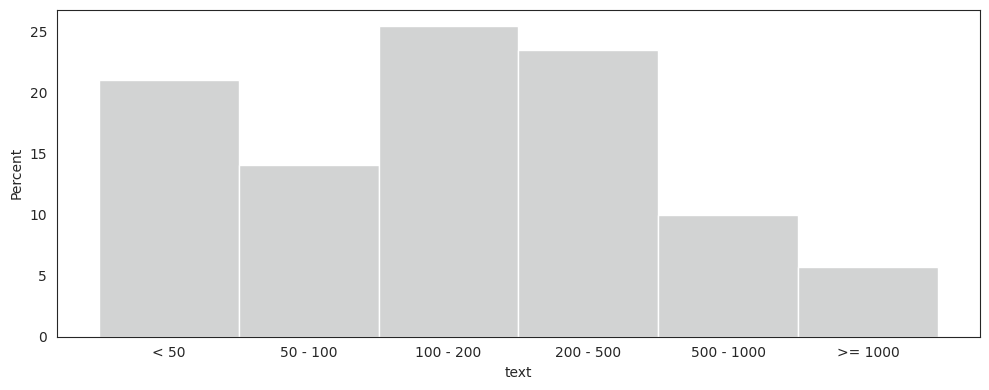

In [28]:
limits = [50, 100, 200, 500, 1000]

fig, ax = plt.subplots(figsize=(10, 4))
lengths = text_lengths.apply(lambda x: discretize_length(x, limits))
lengths = lengths.astype(get_lengths_category(limits))
sns.histplot(lengths, stat="percent", ax=ax, color=secondary_color)
# ax.set_xlim([0, np.max(text_lengths)])
fig.tight_layout()

## WordCloud

In [29]:
reviews_df = pd.read_json(processed_data_dir / f"reviews_text_lemmatization.json.gz")

from wordcloud import WordCloud
from reviews.utils import flat_sentence_tokens


# change the value to black
def black_color_func(
    word, font_size, position, orientation, random_state=None, **kwargs
):
    return "hsl(0,100%, 1%)"


tokens = flat_sentence_tokens(reviews_df[reviews_df["brand"] == "corsair"]["tokens"])

wc = WordCloud(
    height=2000,
    width=3000,
    background_color="white",
    color_func=black_color_func,
    max_words=500,
)
wc.generate_from_frequencies(Counter(tokens))
wc.recolor(color_func=black_color_func)
wc.to_file("../output/wc.png")